## Setup: imports, DM test, lag selection, data loading

In [9]:

from __future__ import annotations
import math
import warnings
from typing import Optional, Tuple, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.api import VAR

warnings.filterwarnings("ignore")


# ----------------------------
# Diebold–Mariano test (two-sided)
# ----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1 + math.erf(z / math.sqrt(2)))


def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse",
) -> Tuple[float, float]:
    """Diebold–Mariano test for equal predictive accuracy."""
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = (e_m**2 - e_r**2) if loss == "mse" else (np.abs(e_m) - np.abs(e_r))

    N = len(d)
    d_mean = d.mean()
    gamma0 = np.var(d, ddof=1)
    var_bar = gamma0 / N

    # HAC adjustment for overlapping horizons
    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w = 1 - k / h
            cov = np.cov(d[k:], d[:-k], ddof=1)[0, 1]
            var_bar += 2 * w * cov / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2 * (1 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


# ----------------------------
# VAR lag selection (AIC-based)
# ----------------------------
def choose_var_lag(
    train: pd.DataFrame,
    max_p: int,
    prev_p: Optional[int] = None,
) -> int:
    """Select VAR lag order using AIC with safe fallback."""
    T, k = train.shape
    p_feasible = max(1, min(max_p, (T - 1) // (k + 1)))

    try:
        sel = VAR(train).select_order(maxlags=p_feasible)
        p = sel.selected_orders.get("aic")
    except Exception:
        p = None

    if p is None:
        p = prev_p if prev_p is not None else min(2, p_feasible)

    return int(max(1, min(p, p_feasible)))


# ----------------------------
# Load monthly data
# ----------------------------
url = (
    "https://raw.githubusercontent.com/bredeespelid/"
    "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_monthly.csv"
)

df = pd.read_csv(url)

# Standardise date index
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
elif "DATE" in df.columns:
    df["Date"] = pd.to_datetime(df["DATE"])
else:
    raise KeyError("Neither 'Date' nor 'DATE' found in the dataset.")

df = df.sort_values("Date").set_index("Date")

# Required variables
required_cols = ["EUR_NOK", "d_pi", "dI_t", "Q"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}")

# Endogenous block
df = df.copy()
df["s"] = np.log(df["EUR_NOK"])
endog_vars = ["s", "d_pi", "dI_t", "Q"]
endog = df[endog_vars].dropna()
dates = endog.index

print(f"Loaded monthly data: {df.index.min().date()} → {df.index.max().date()}")
print(f"Usable observations: {len(endog)}")
print("Endogenous variables:", endog_vars)


Loaded monthly data: 2000-01-31 → 2025-11-30
Usable observations: 311
Endogenous variables: ['s', 'd_pi', 'dI_t', 'Q']


## Monthly VAR walk-forward 


Monthly VAR – Walk-forward forecast (EUR/NOK)
Completed 275 forecasts.

=== Monthly VAR Performance (EUR/NOK) ===
Observations: 275
RMSE: 0.240012
MAE : 0.175657
Directional accuracy: 49.6%

=== Diebold–Mariano vs Random Walk (Monthly VAR) ===
DM statistic: 1.8587
p-value     : 0.0631


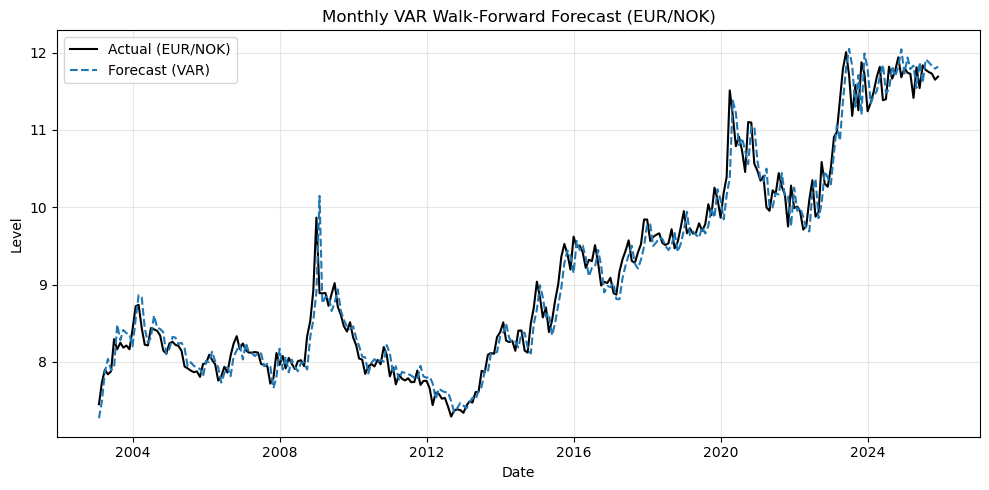


Average selected VAR lag: 2.51
Saved plot: VAR_monthly_forecast.png


In [10]:
min_train_months = 36
max_p = 6

rows_m = []
prev_p_monthly = None

for i in range(min_train_months, len(dates)):
    d_prev = dates[i - 1]
    d_curr = dates[i]

    # Expanding window up to previous month
    train = endog.loc[:d_prev]

    # Lag selection
    p = choose_var_lag(train, max_p=max_p, prev_p=prev_p_monthly)
    prev_p_monthly = p

    # Fit VAR and forecast log spot one month ahead
    model = VAR(train).fit(p)
    y0 = train.values[-p:]
    f_vec = model.forecast(y0, steps=1)[0]
    f = pd.Series(f_vec, index=endog_vars)

    obs = endog.loc[d_curr]

    rows_m.append(
        {
            "date": d_curr,
            "s_true": float(np.exp(obs["s"])),
            "s_pred": float(np.exp(f["s"])),
            "p_used": p,
        }
    )

df_eval_m = pd.DataFrame(rows_m).set_index("date")


print("\n==============================")
print("Monthly VAR – Walk-forward forecast (EUR/NOK)")
print("==============================")
print(f"Completed {len(df_eval_m)} forecasts.")


# ---------------- Evaluate monthly VAR ----------------
def evaluate_monthly_var(df_eval_m: pd.DataFrame) -> pd.DataFrame:
    df = df_eval_m.copy()
    df["err"] = df["s_true"] - df["s_pred"]
    core = df.dropna(subset=["s_true", "s_pred"])

    rmse = float(np.sqrt(np.mean(core["err"]**2))) if len(core) else np.nan
    mae = float(mean_absolute_error(core["s_true"], core["s_pred"])) if len(core) else np.nan

    # Directional accuracy
    core["y_prev"] = core["s_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "s_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "s_pred"] - core.loc[mask, "y_prev"])
    hit_rate = (dir_true == dir_pred).mean() if mask.any() else np.nan

    print("\n=== Monthly VAR Performance (EUR/NOK) ===")
    print(f"Observations: {len(core)}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE : {mae:.6f}")
    if mask.any():
        print(f"Directional accuracy: {hit_rate*100:.1f}%")

    return core.rename(columns={"s_true": "y_true", "s_pred": "y_pred"})


# ---------------- DM Test ----------------
def dm_against_random_walk_monthly(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)

    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)

    print("\n=== Diebold–Mariano vs Random Walk (Monthly VAR) ===")
    print(f"DM statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")


# Run evaluation + DM
eval_m = evaluate_monthly_var(df_eval_m)
dm_against_random_walk_monthly(eval_m, loss="mse", h=1)

# ---------------- Plot ----------------
plt.figure(figsize=(10, 5))
plt.plot(df_eval_m.index, df_eval_m["s_true"], label="Actual (EUR/NOK)", color="black")
plt.plot(df_eval_m.index, df_eval_m["s_pred"], "--", label="Forecast (VAR)")
plt.title("Monthly VAR Walk-Forward Forecast (EUR/NOK)")
plt.xlabel("Date")
plt.ylabel("Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save PNG
plt.savefig("VAR_monthly_forecast.png", dpi=300, bbox_inches="tight")

plt.show()

print(f"\nAverage selected VAR lag: {df_eval_m['p_used'].mean():.2f}")
print("Saved plot: VAR_monthly_forecast.png")

